# PCA

The PCA is one of the most common dimensionality reduction techniques on the Data Science realm. On this notebook a deep study of the method will be done and some advanced aspects gathered from this [paper](https://www.researchgate.net/publication/255728363_Permutation_tests_to_estimate_significances_on_Principal_Components_Analysis) will be analyzed. 

In [59]:
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris, load_wine, load_breast_cancer

## PCA Implementation

Let's implement the PCA from the ground-zero. The following steps are required to build the PCA and they will be explained in more detail later on the notebook:
- Normalize and centralize the data
- Calculate the covariance matrix
- Calculate the eigenvalues and eigenvectors from the covariance matrix
- Select the number of dimensions
- Apply the space transformation to the original data

For this implementation we will be looking in greater detail to the Iris dataset because it is a small dataset with few dimensions, so we can have a better understanding of the inner workings of the PCA.

First, let's define a function to plot the pairs of columns from a given dataset.

In [60]:
def plot_dataset(X, y):
    combinations = list(itertools.combinations([i for i in range(X.shape[1])], 2))
    n_comb = len(combinations)
    
    if n_comb == 0:
        fig = make_subplots(rows=1, cols=1)
        fig.add_trace(
            go.Scatter(x=list(X.flatten()), y=[0 for i in range(len(X))], mode='markers', marker=dict(color=y)),
            row=1, col=1
        )
        fig.update_layout(height=1000, width=1000, title_text="Dataset Columns Pairs")
        fig.show()
        return
    
    elif n_comb == 1:
        rows = 1
        cols = 1
    else:
        rows = int(n_comb / 2)
        cols = 2

    fig = make_subplots(rows=rows, cols=cols)
    flag = True
    
    col = 1
    i = 1

    for combination in combinations:
        if i > rows:
            i = 1
            col = 2
            
        fig.add_trace(
            go.Scatter(x=list(X[:,combination[0]]), y=list(X[:, combination[1]]), mode='markers', marker=dict(color=y)),
            row=i, col=col
        )
        fig.add_vline(x=0, row=i, col=col)
        fig.add_hline(y=0, row=i, col=col)
        i += 1

    fig.update_layout(height=1000, width=1000, title_text="Dataset Columns Pairs")
    fig.show()

Now, let's grab the Iris dataset and see how it behave.

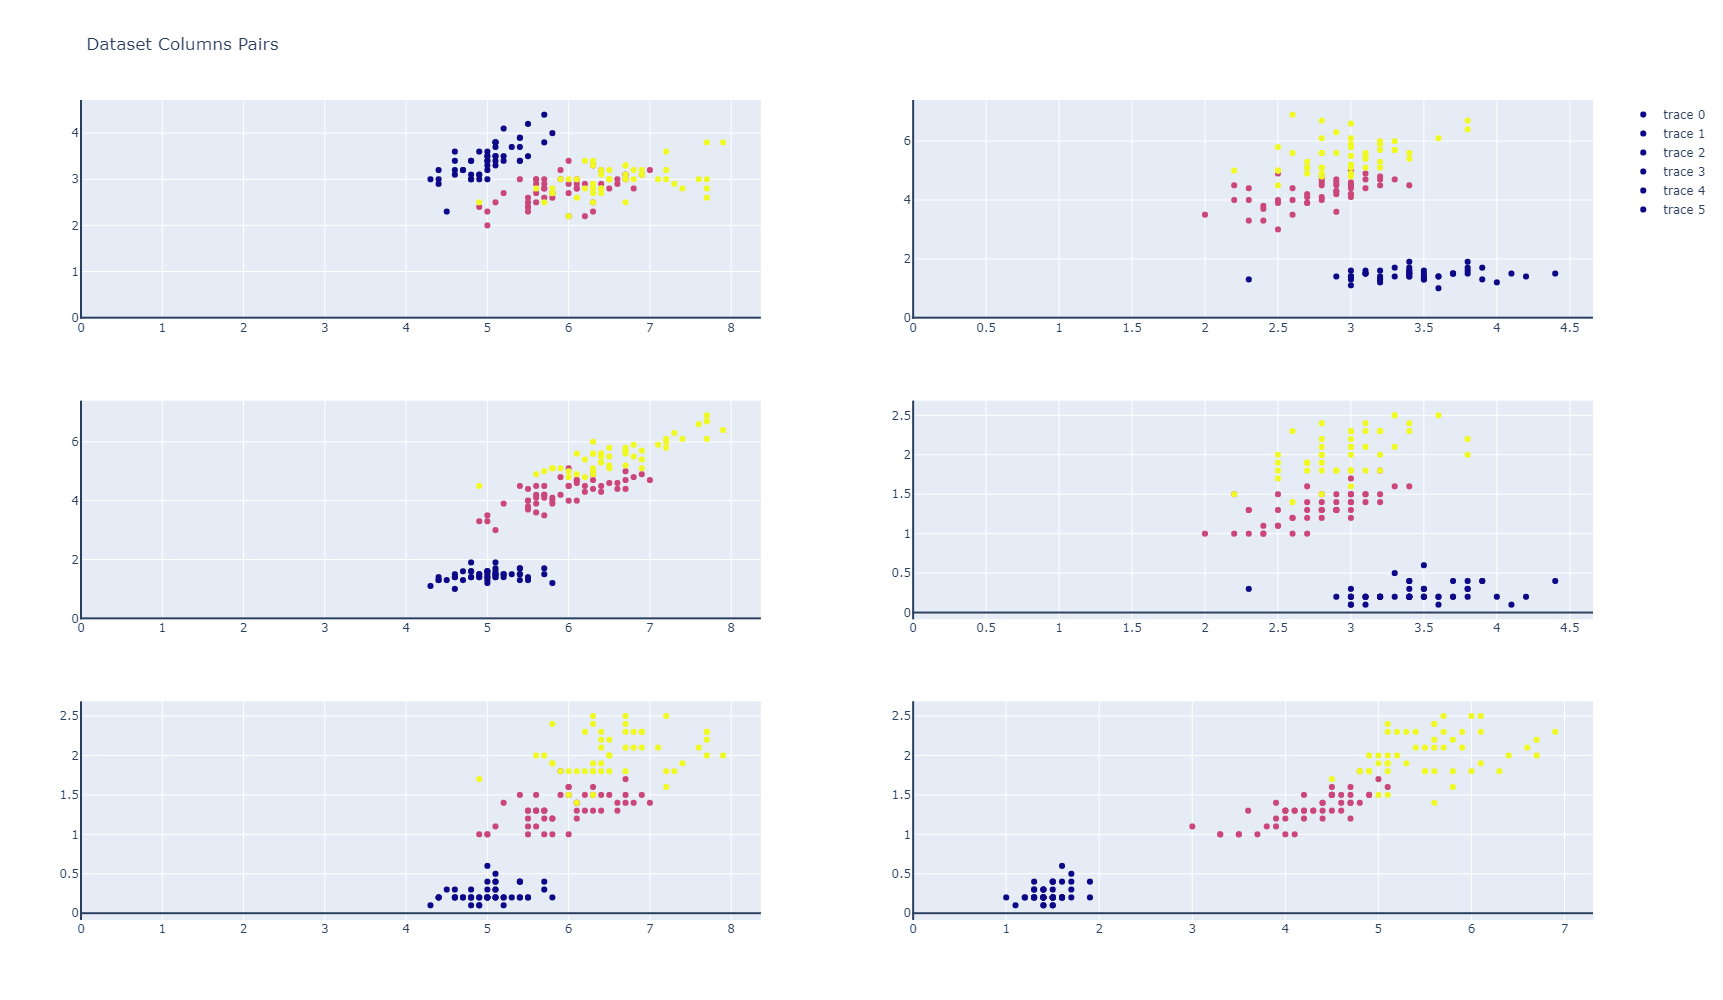

In [61]:
X, y = load_iris(return_X_y = True)
plot_dataset(X, y)

As we can see, on some dimensions the division between classes are clearer than on others. You can see that the data is not normalized given the range of the variables that go up to 8 on some cases.

Because the PCA measures variance, it is useful to normalize the data before applying it so we can be sure that one variable will not dominate over the other because it has a bigger scale.

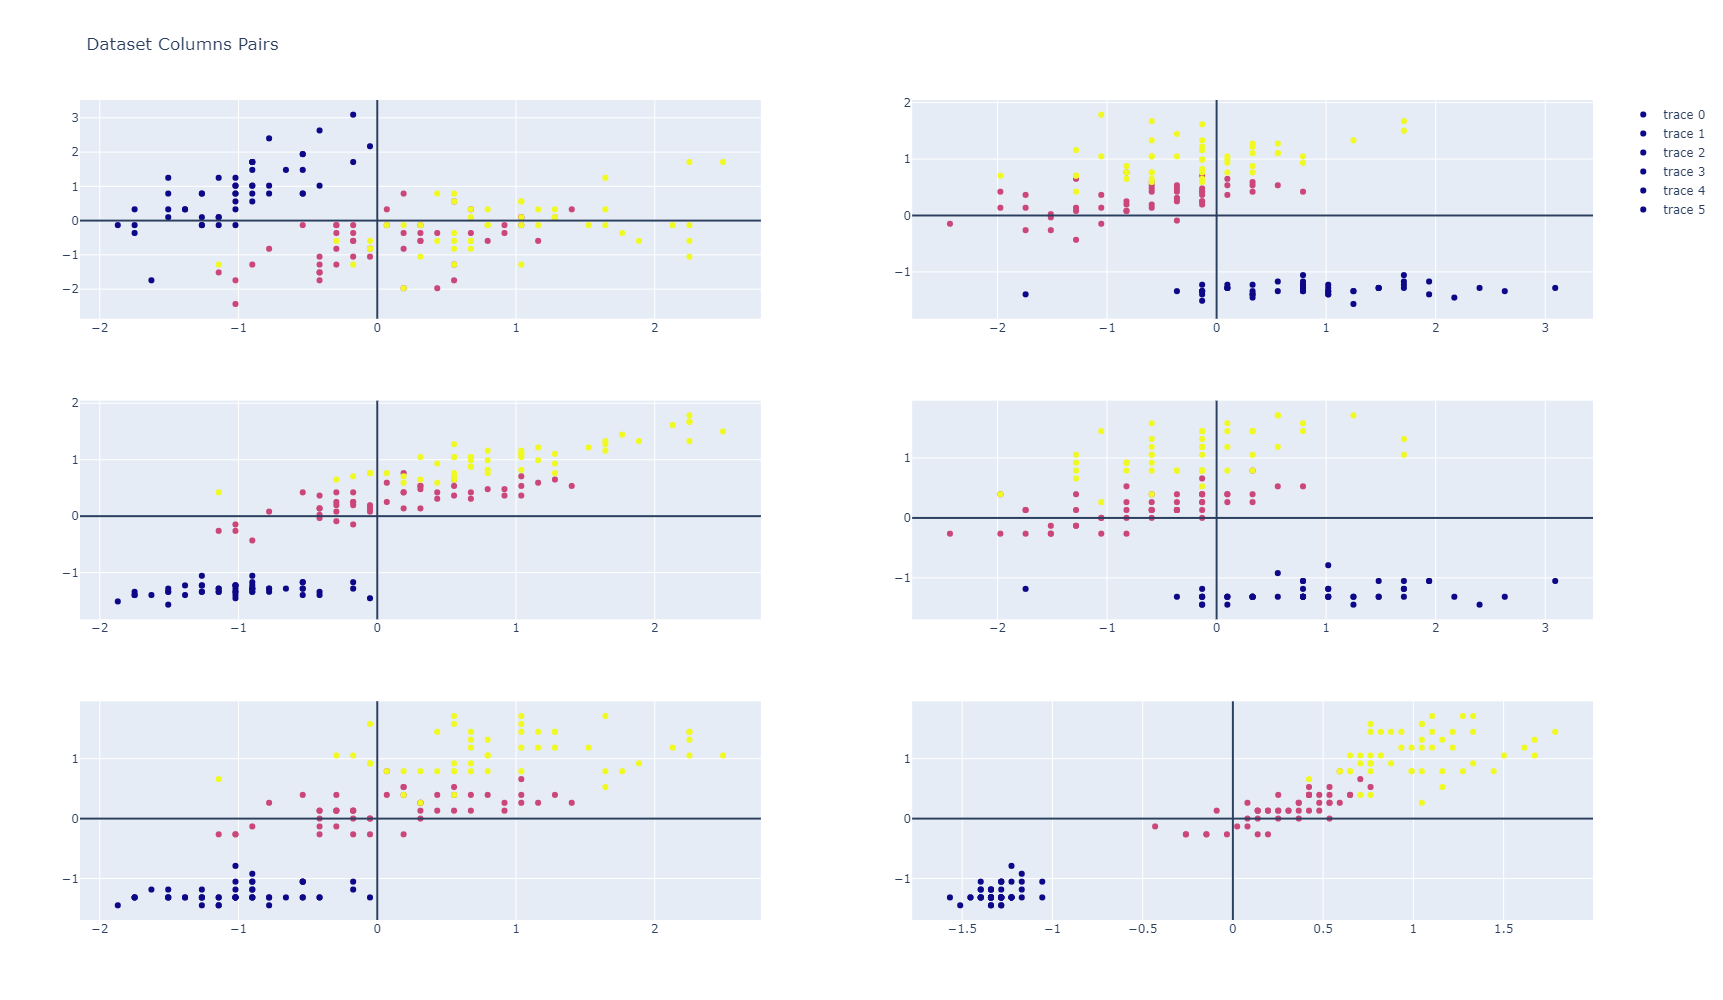

In [62]:
# Normalization
X = StandardScaler().fit_transform(X)
plot_dataset(X, y)

Now we will calculate the covariance matrix of that normalized dataset. The covariance measures if variables are correlated with other, this is: if they grow together or if they decrease together.

One can think about the covariance as the 'not normalized' correlation matrix because it only tell us the direction of the relation but not the strength of this relation.

In [63]:
# Covariance Matrix
# Numpy works with transposed datasets on this function, so we need to use th rowvar=False
cov_matrix = np.cov(X, rowvar=False)
cov_matrix

array([[ 1.00671141, -0.11835884,  0.87760447,  0.82343066],
       [-0.11835884,  1.00671141, -0.43131554, -0.36858315],
       [ 0.87760447, -0.43131554,  1.00671141,  0.96932762],
       [ 0.82343066, -0.36858315,  0.96932762,  1.00671141]])

Now we calculate the eigenvectors and eigenvalues from this matrix. The eigenvectors will be the axis of the new space and will point towards the 'line' of greater variance on our original space.

We will then sort the eigenvectors by the value of their eigenvalue. The bigger the eigenvalue, the greater the explained variance by that eigenvector.

In [64]:
# Eigenvectors and eigenvalues
eig_val, eig_vec = np.linalg.eig(cov_matrix)

In [65]:
# Sorting the eigenvalues and eigenvectors
idx = eig_val.argsort()[::-1]
eig_val = eig_val[idx]
eig_vec = eig_vec[:, idx]

In [66]:
eig_val

array([2.93808505, 0.9201649 , 0.14774182, 0.02085386])

If we divide the value of each eigenvalue by the sum of the eigenvalues we will get the the explained variance by each of the eigenvectors.

In [67]:
# Obtaining the explained variance by each
variance = eig_val / sum(eig_val)
variance

array([0.72962445, 0.22850762, 0.03668922, 0.00517871])

Here we can see that the first eigenvector alone is responsible for 72% of the variance of the dataset.

In [68]:
# Selecting the first two components
n_components = 2
print(f'Explained Variance by the first {n_components} components: {sum(variance[0:n_components])}')
feature_vector = eig_vec[:, 0:n_components]

Explained Variance by the first 2 components: 0.9581320720000164


Now, to apply the PCA to the dataset we will multiply the eigenvectors transposed by the dataset transposed. This will generate the transformed dataset on the new space of the principal components.

In [69]:
PCA_X = np.matmul(feature_vector.T, X.T).T

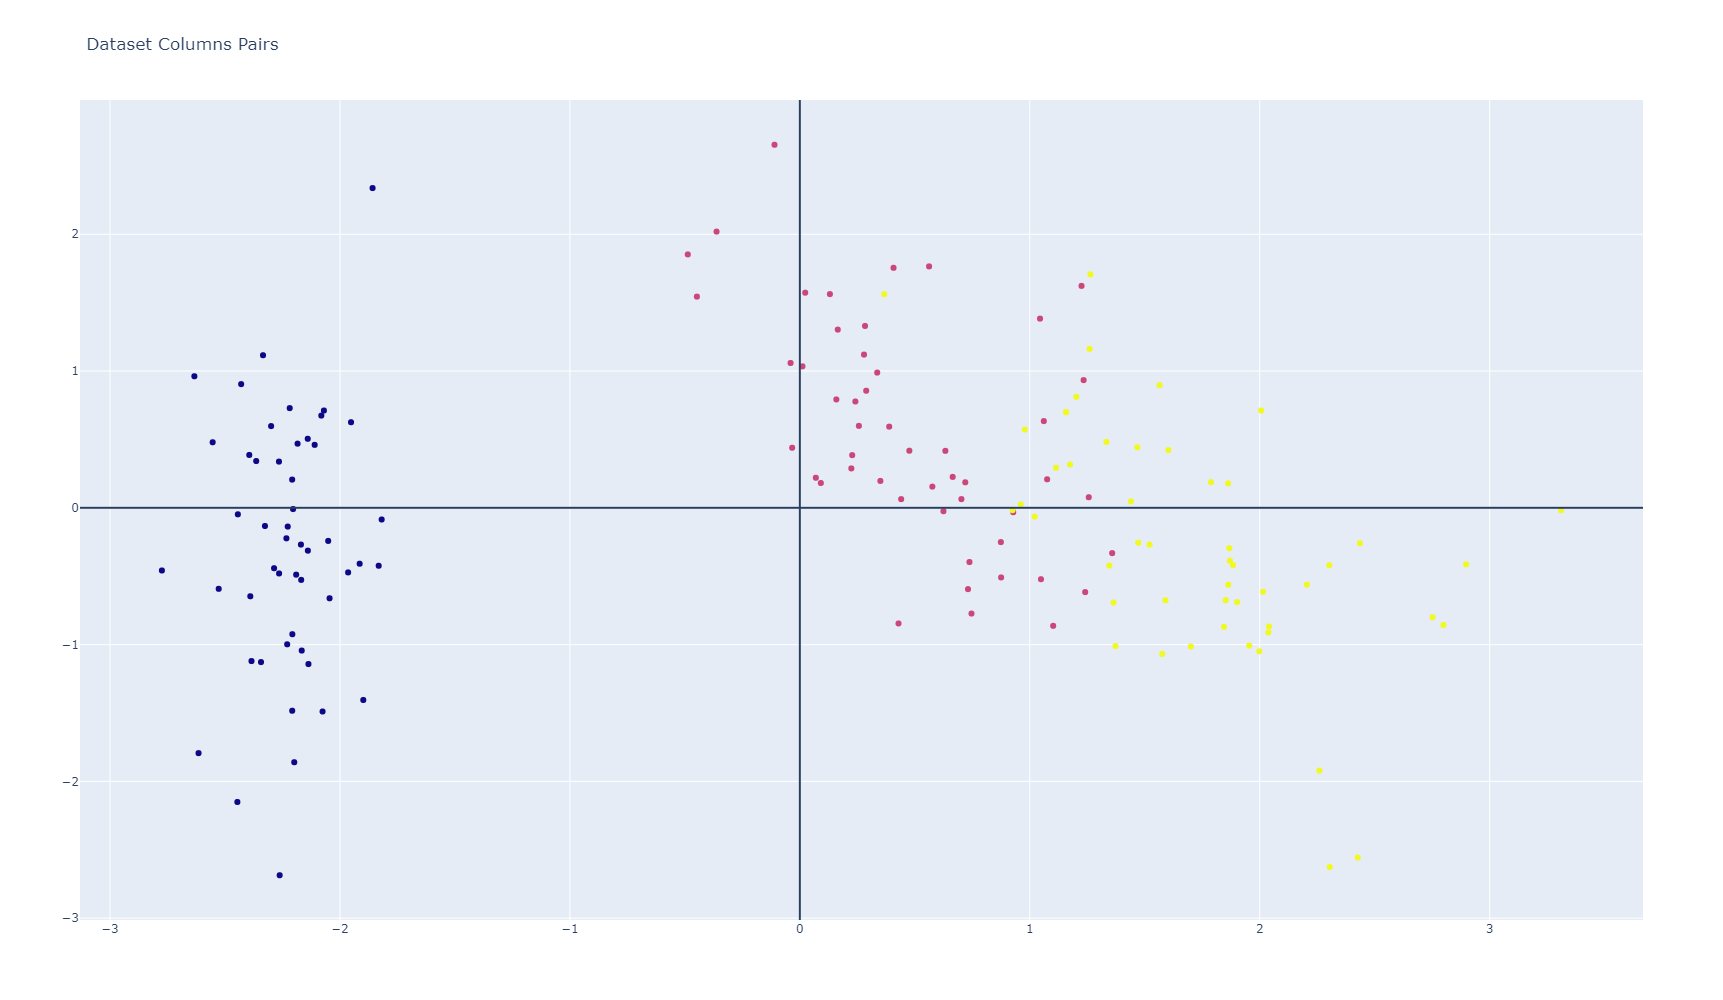

In [70]:
plot_dataset(PCA_X, y)

As we can see, this new dataset has only two dimensions and we can see a very good separation between the classes with only a little overlap with the classes 1 and 2.

If we would go even far and use only 1 principal component, we would have the following:

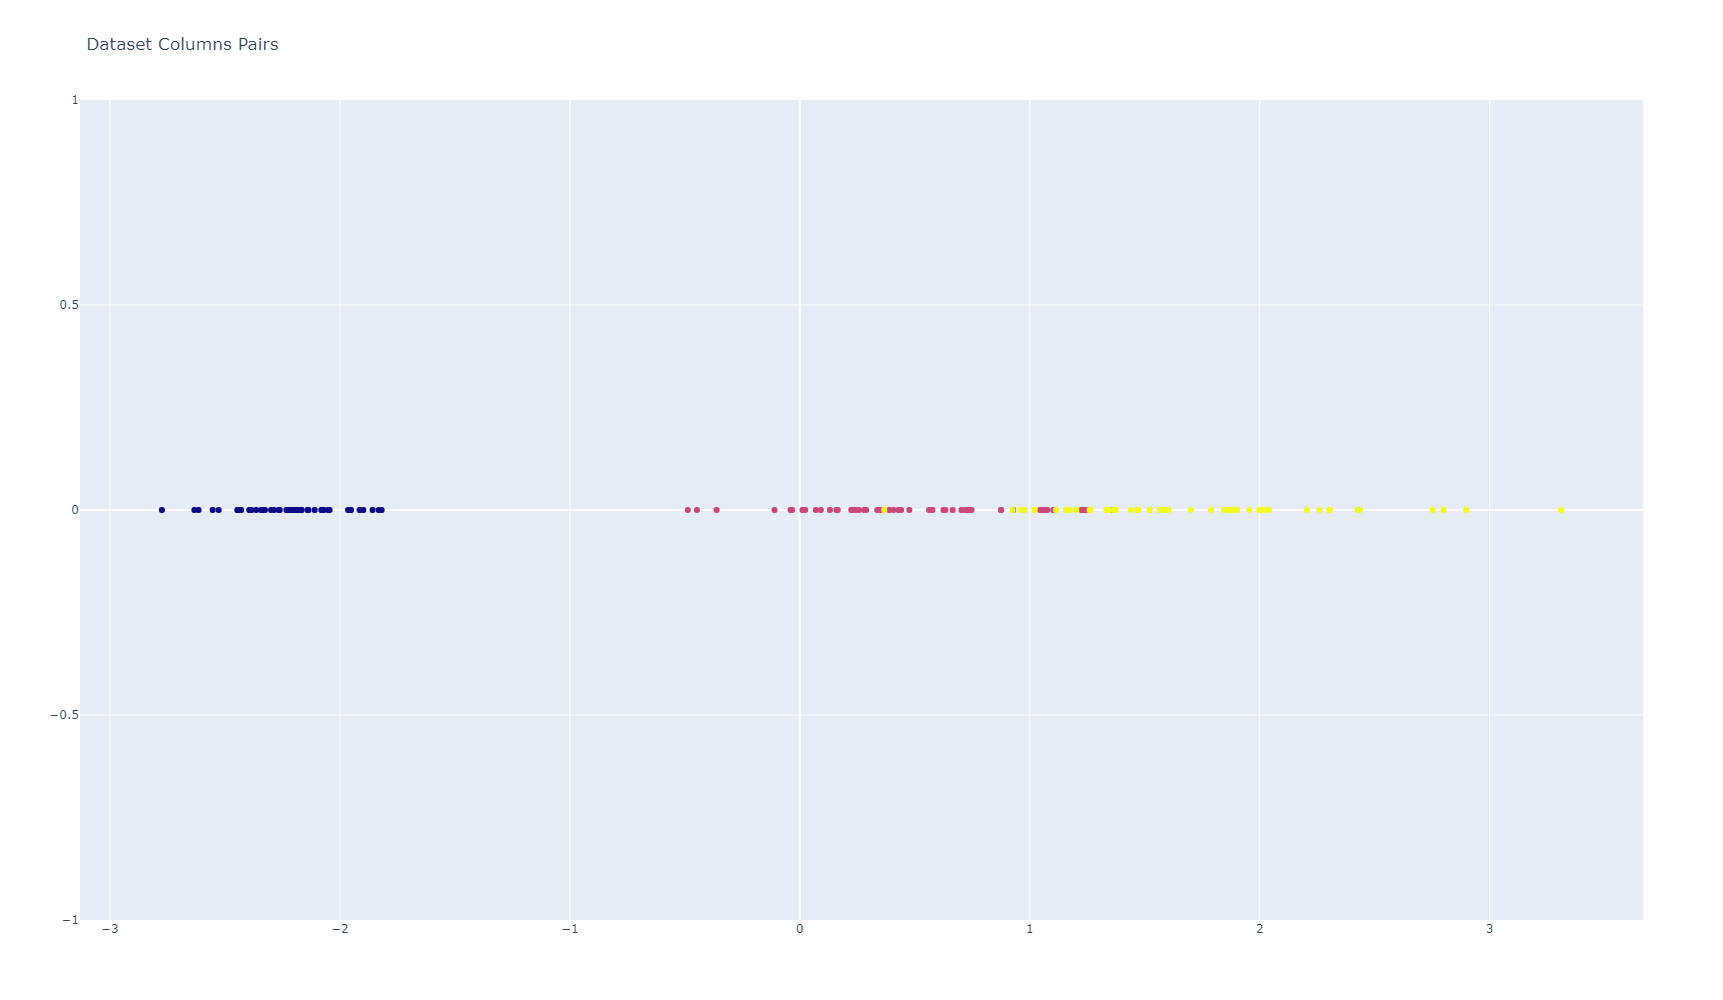

In [71]:
feature_vector = eig_vec[:, 0:1]
PCA_X = np.matmul(feature_vector.T, X.T).T
plot_dataset(PCA_X, y)

As expected we will have more overlap because less variance is explained, however, we still see a good division between the classes.

## Statistics for usefulness of PCA

First of all, we should be able to answer the question: it is worth it to apply PCA on our data? The PCA does not work well when the variables are uncorrelated with each other, because on this case, the explained variance by each Principal Component will be close to the variance of the variables itself, so we will not have a dimensionality reduction as we expect.

There are several methods to assess if PCA is a good option for a dataset. On this section we will talk about them and see how we can apply them.

### Generalized Variance

The generalized variance is the determinant of the covariance matrix. Its geometrical interpretation is the hyper-volume generated by the dataset on the space. It decreases with a greater amount of covariance, so smaller values are better.

The idea is that if the variables are highly correlated, then this hyper-volume will tend to shrink to a lower dimension. The minimum value for this metric is zero and the maximum value (no correlation at all) is the trace of the matrix.

In [72]:
def generalized_variance(X, normalize=True):
    cov = np.cov(X, rowvar=False)
    if normalize:
        return np.linalg.det(cov) / np.trace(cov)
    else:
        return np.linalg.det(cov)

### Scatter Coefficient

It is basically the same of the generalized variance, however, it uses the correlation matrix instead of the covariance matrix. In this case, the maximum value for the metric will be the number of dimensions.

In [73]:
def scatter_coefficient(X, normalize=True):
    corr = np.corrcoef(X, rowvar=False)
    if normalize:
        return np.linalg.det(corr) / np.trace(corr)
    else:
        return np.linalg.det(corr)

### $\psi$ Index

This metric looks for the magnitude of the eigenvalues taken from the correlation matrix. If the variables are uncorrelated, each PC tends to explain as much variance as a single variable and their eigenvalues tend to 1. Therefore, the closer to the y = 1 row, the smaller the area and the more uncorrelated the dataset.

For this metric, bigger values are better. Its maximum value is p(p-1) and its minimum value is zero. It is given by the equation:

$$\psi = \sum (\lambda_i - 1)^2$$

In [74]:
def psi_index(X, normalize=False):
    corr = np.corrcoef(X, rowvar=False)
    
    # Eigenvalues and eigenvectors from the correlation matrix
    eig_val, eig_vec = np.linalg.eig(corr)
    idx = eig_val.argsort()[::-1]
    eig_val = eig_val[idx]

    if normalize:
        p = X.shape[0]
        return np.sum((eig_val - 1)**2) / (p*(p-1))
    else:
        return np.sum((eig_val - 1)**2)

### Index of a Matrix

It compares the biggest and smallest eigenvalues and its applied to the correlation matrix. With increasing correlation, we have increased metric. This, however, neglects the distribution of variance allocated to all other PCs. It is given by the formula:

$$\sqrt{\frac{\lambda_1}{\lambda_p}}$$

In [75]:
def index_of_matrix(X):
    corr = np.corrcoef(X, rowvar=False)
    
    # Eigenvalues and eigenvectors from the correlation matrix
    eig_val, eig_vec = np.linalg.eig(corr)
    idx = eig_val.argsort()[::-1]
    eig_val = eig_val[idx]
    
    return np.sqrt(eig_val[0]/eig_val[-1])

### Information Statistic

Tries to take into account all the eigenvalues, however, this makes this metric has no upper bound. The formula is given by:

$$-\frac{1}{2} \sum \ln{\lambda_i}$$

In [76]:
def information_statistic(X):
    corr = np.corrcoef(X, rowvar=False)
    
    # Eigenvalues and eigenvectors from the correlation matrix
    eig_val, eig_vec = np.linalg.eig(corr)
    idx = eig_val.argsort()[::-1]
    eig_val = eig_val[idx]
    
    return -(1/2) * np.sum(np.log(eig_val))

### Divergence Statistic

Similar to the one before. However, tries to normalize the values using a fraction and not a log. Given by the following formula:

$$\sum \frac{1 - \lambda_i}{2 \lambda_i}$$

In [77]:
def divergence_statistic(X):
    corr = np.corrcoef(X, rowvar=False)
    
    # Eigenvalues and eigenvectors from the correlation matrix
    eig_val, eig_vec = np.linalg.eig(corr)
    idx = eig_val.argsort()[::-1]
    eig_val = eig_val[idx]
    
    return np.sum((1 - eig_val) / (2*eig_val))

In [78]:
generalized_variance(X)

0.002068497465167302

In [79]:
scatter_coefficient(X)

0.0020274027026378366

In [80]:
psi_index(X)

5.375047892849886

In [81]:
index_of_matrix(X)

11.869677852761525

In [82]:
information_statistic(X)

2.4073527004204616

In [83]:
divergence_statistic(X)

26.262633442446703

## Permutation Test for Components Selection

So, how do we select the actual number of Principal Components we should use? Usually one would define a threshold of explained variance (such as 80% or 90%) and cut-off the components once this value is achieved.

However, some of that variance may as well be noise on our dataset and adding them would hurt the performance. To solve that, one can generate permutation tests on the PCA to find out how many Principal Components should be used. The method implemented here is based on the one found on a R snippet from [this post](https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868?source=collection_tagged---------21-------------------------------) on Medium.

The basic idea here is to remove the correlation between the features of the dataset by doing permutations of the columns of the dataset independently from each other and then verify the amount of variance explained by each Principal Component. It is expected that the variance explained by the component, if it should be used, will be greater than te variance generated by chance on an uncorrelated dataset. This is what we are going to verify.

In [84]:
# This function changes the order of the columns independently to remove correlations
def de_correlate_df(df):
    X_aux = df.copy()
    for col in df.columns:
        X_aux[col] = df[col].sample(len(df)).values
        
    return X_aux

In [85]:
df = pd.DataFrame(X)

We will set a number of permutations, for each permutation we will calculate the PCA and save the explained variance ratio for each PC.

In [86]:
pca = PCA()
pca.fit(df)

original_variance = pca.explained_variance_ratio_

N_permutations = 1000

variance = np.zeros((N_permutations, len(df.columns)))

for i in range(N_permutations):
    X_aux = de_correlate_df(df)
    
    pca.fit(X_aux)
    variance[i, :] = pca.explained_variance_ratio_

Let's look now at the average explained variance ratio of the permuted datasets in comparison with the non-permuted dataset.

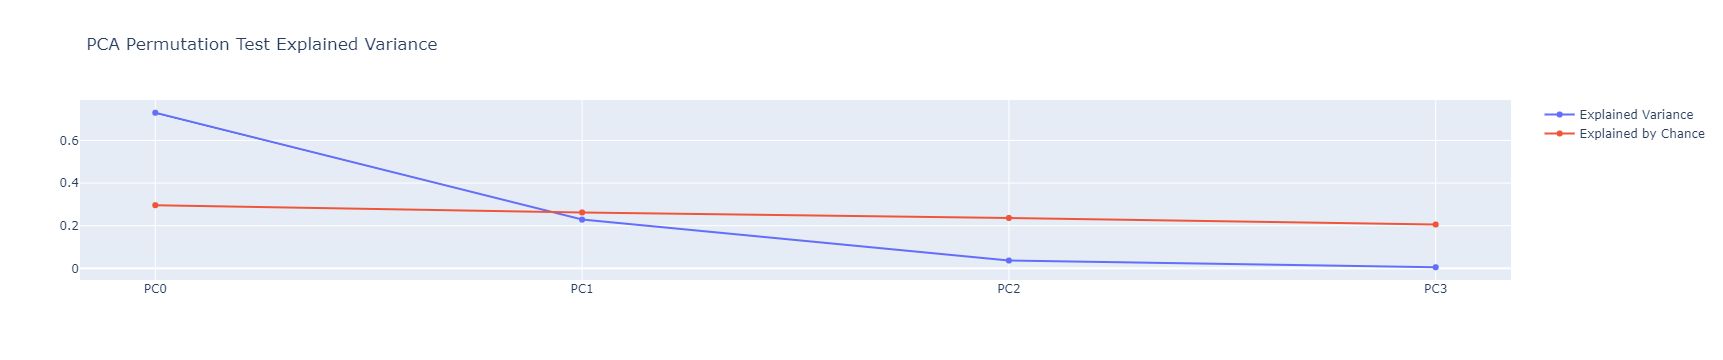

In [87]:
average_permuted_variance = np.mean(variance, axis=0)

fig = go.Figure()

fig.add_trace(go.Scatter(x=[f'PC{i}' for i in range(len(df.columns))], y=original_variance, name='Explained Variance'))
fig.add_trace(go.Scatter(x=[f'PC{i}' for i in range(len(df.columns))], y=average_permuted_variance, name='Explained by Chance'))

fig.update_layout(title="PCA Permutation Test Explained Variance")

fig.show()

As we can see, it seems that only the first PC presents a variance greater than one we would expect to find on a uncorrelated dataframe. Let's calculate the p-value for this analysis.

To do so, we will count the number of times each PC explained variance ratio is bigger than the original case and normalize it by the number of permutations.

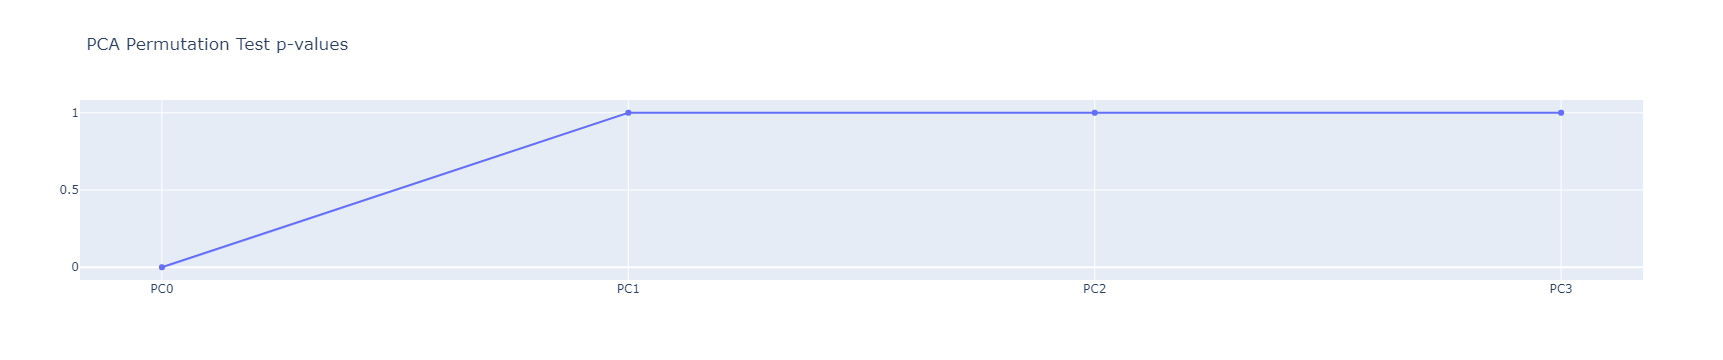

In [88]:
p_val = np.sum(variance > original_variance, axis=0) / N_permutations

fig = go.Figure()
fig.add_trace(go.Scatter(x=[f'PC{i}' for i in range(len(df.columns))], y=p_val, name='p-value on significance'))

fig.update_layout(title="PCA Permutation Test p-values")

So, according to this test, only the first PC should be used. However, as with any statistical test, this test is not perfect. We saw by the scatter plots that two PCs would yield a better space separation of the classes. This is probably due to the low dimension and low number of instances on the Iris dataset.

### Difference of Roots

The method above is called the equality of roots since it measures how each PC changes from the one of the same rank on the random dataset. There is, however, another way of doing that: we can make the diff of the variances for each pair of PC and then compare it to the result from the random experiment and define our p-value as the times it was greater than the original.

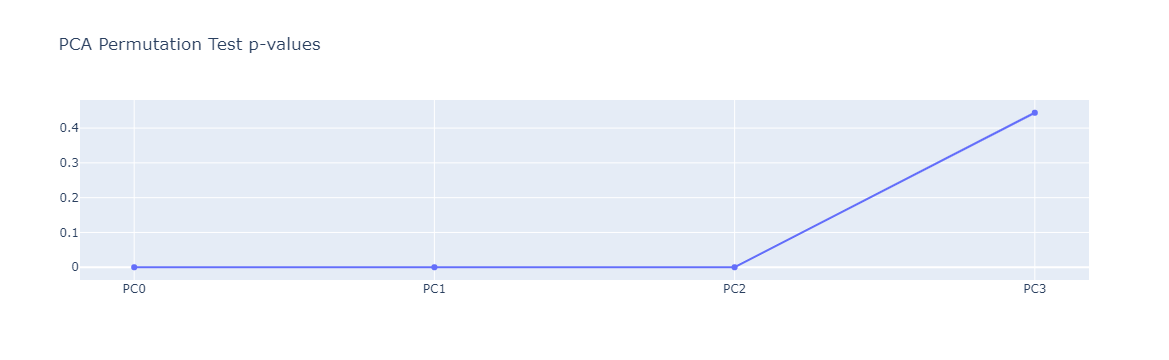

In [89]:
p_val = np.sum(np.abs(np.diff(variance, axis=1, prepend=0)) > np.abs(np.diff(original_variance, prepend=0)), axis=0) / N_permutations

fig = go.Figure()
fig.add_trace(go.Scatter(x=[f'PC{i}' for i in range(len(df.columns))], y=p_val, name='p-value on significance'))

fig.update_layout(title="PCA Permutation Test p-values")

## Interpretability of PCA

One of the biggest issues with using PCA on some domains is that it makes interpretability of the model a little bit more difficult. Because each PC is composed of several variables, applying a SHAP on the model, for example, will not tell us much about the impact of each feature on the model.

However, we can start to sutudy some ways of overcoming this. First of all, let's understandthe concept of loading. For that, let's remember that each PC is a linear combination of the features of our dataset, so we can write it as follows:

$$ PC_1 = w_{1,1}X_1 + w_{1,2}X_2 + \dots + w_{1,n}X_n$$

The weights of this linear combination (the $w_{x,y}$) are the loadings of the Principal Component. You can see right away that this can give us an idea of how much each variable impacts each component.

You can also see that these values are the eigenvector values on each of the dimensions of the original dataset. It is useful, however, to multiply those loadings by the square-root of the eigenvalues as a form of normalization.

With this in hands, we can start creating measures to relate each feature to each Principal Component.

### Correlation Between Features and PCs

We can calculate how likely was each variable to be associated with each PC by calculating the correlation of the PC with the variables. To do so, we will use:

$$r_{ij} = \frac{u_{ij} \sqrt{\lambda_i}}{s_j}$$

Where $r_{ij}$ is the correlation between the $i^{th}$ PC and the $j^{th}$ variable, the $u_{ij}$ is the loading of the $j^{th}$ on the $i^{th}$ PC and $s_j$ is the standard deviation of the $j^{th}$ variable.

This metric, however, presents some problems because the sign of the loadings can change.

In [90]:
def correlation_matrix(cov_matrix):
    eig_val, eig_vec = np.linalg.eig(cov_matrix)
    r = np.zeros((len(eig_vec), cov_matrix.shape[0]))
    for i in range(len(eig_vec)):
        for j in range(cov_matrix.shape[0]):
            r[i][j] = (eig_vec[i][j] * np.sqrt(eig_val[i])) / np.sqrt(cov_matrix[j][j])
            
    return r

### Index of the Loadings (IL)

With this metric, we square the values on the numerator to avoid the permutation of sign and also to allow only high loadings and high eigenvalues to be considered in a significant manner. The equation is:

$$IL_{ij} = \frac{u_{ij}^2 \lambda_i^2}{s_j}$$

In [91]:
def index_of_loadings_matrix(cov_matrix):
    eig_val, eig_vec = np.linalg.eig(cov_matrix)
    r = np.zeros((len(eig_vec), cov_matrix.shape[0]))
    for i in range(len(eig_vec)):
        for j in range(cov_matrix.shape[0]):
            r[i][j] = (eig_vec[i][j]**2 * eig_val[i])**2 / np.sqrt(cov_matrix[j][j])

    return r

In [92]:
correlation_matrix(cov_matrix)

array([[ 0.89016876, -0.64476559, -1.2292792 ,  0.44637133],
       [-0.25750946, -0.88271627,  0.23364106, -0.1180813 ],
       [ 0.22234964, -0.00938246,  0.05444699, -0.30702607],
       [ 0.08129782, -0.00963473,  0.09128865,  0.0753595 ]])

In [93]:
index_of_loadings_matrix(cov_matrix)

array([[6.34230161e-01, 1.74568105e-01, 2.30653272e+00, 4.00998413e-02],
       [4.44150606e-03, 6.13256288e-01, 3.00991427e-03, 1.96373089e-04],
       [2.46889836e-03, 7.82751081e-09, 8.87673077e-06, 8.97549687e-03],
       [4.41238232e-05, 8.70392015e-09, 7.01495163e-05, 3.25768844e-05]])

## Datasets Experiments

On this section we will try to use the metrics defined above to see the usefulness of them. The step-by-step procedure is stated as follows:

- Grab 3 real datasets (Iris, Wine and Breast Cancer)
- Create 2 synthetic datasets, one iris half-correlated and one uncorrelated
- Run the usefullness metrics for each one
- Run the permutation test for each one
- Apply a model with and without PCA for every dataset
    - Apply the PCA with all components
    - Apply the PCA with a selected number of components to 80% of variance
    - Apply the PCA with the permutation test

### Getting the Real Datasets

In [94]:
iris_X, iris_y = load_iris(return_X_y=True)
wine_X, wine_y = load_wine(return_X_y=True)
cancer_X, cancer_y = load_breast_cancer(return_X_y=True)

### Creating the Synthetic Datasets

In [95]:
uncorr_dataset = pd.DataFrame()
for i in range(15):
    uncorr_dataset[f'f{i}'] = np.random.normal(loc=i, scale=(i + 1)/2, size=500)

uncorr_dataset_y = pd.DataFrame()
for i in range(5):
    df = pd.DataFrame()
    df['target'] =  [i for j in range(100)]
    uncorr_dataset_y = uncorr_dataset_y.append(df)

In [96]:
semi_corr_dataset = pd.DataFrame(iris_X)
for i in range(10):
    semi_corr_dataset[f'f{i}'] = np.random.normal(loc=i, scale=(i + 1)/2, size=150)

In [97]:
# Normalizing the datasets
iris_X = StandardScaler().fit_transform(iris_X)
wine_X = StandardScaler().fit_transform(wine_X)
cancer_X = StandardScaler().fit_transform(cancer_X)
uncorr_dataset = StandardScaler().fit_transform(uncorr_dataset)
semi_corr_dataset = StandardScaler().fit_transform(semi_corr_dataset)

In [98]:
datasets_X = [uncorr_dataset, semi_corr_dataset, iris_X, wine_X, cancer_X]
datasets_y = [uncorr_dataset_y, iris_y, iris_y, wine_y, cancer_y]

### Running the Usefullness Metrics

In [99]:
names = ['Uncorrelated', 'Semi-Correlated', 'Iris', 'Wine', 'Breast Cancer']

use_metrics = pd.DataFrame()
for i, X in enumerate(datasets_X):
    df = pd.DataFrame()
    
    df = df.append({'metric': 'generalized_variance', 'value': generalized_variance(X)}, ignore_index=True)
    df = df.append({'metric': 'scatter_coefficient', 'value': scatter_coefficient(X)}, ignore_index=True)
    df = df.append({'metric': 'index_of_matrix', 'value': index_of_matrix(X)}, ignore_index=True)
    df = df.append({'metric': 'psi_index', 'value': psi_index(X)}, ignore_index=True)
    df = df.append({'metric': 'information_statistic', 'value': information_statistic(X)}, ignore_index=True)
    df = df.append({'metric': 'divergence_statistic', 'value': divergence_statistic(X)}, ignore_index=True)
    
    df['dataset'] = names[i]
    
    use_metrics = use_metrics.append(df, ignore_index=False)

In [100]:
use_metrics.pivot_table(index='dataset', columns='metric', values='value').reset_index()

metric,dataset,divergence_statistic,generalized_variance,index_of_matrix,information_statistic,psi_index,scatter_coefficient
0,Breast Cancer,5044.701005,7.302237e-33,315.955801,35.323471,196.077668,6.939081e-33
1,Iris,26.262633,2.068497e-03,11.869678,2.407353,5.375048,2.027403e-03
2,Semi-Correlated,29.481371,3.678815e-04,12.777970,2.677825,6.478079,3.372431e-04
3,Uncorrelated,0.238660,5.405816e-02,1.377891,0.118836,0.488140,5.256405e-02
4,Wine,12.141029,3.857912e-05,6.746913,3.832728,20.116901,3.605716e-05


### Running the Permutation Test

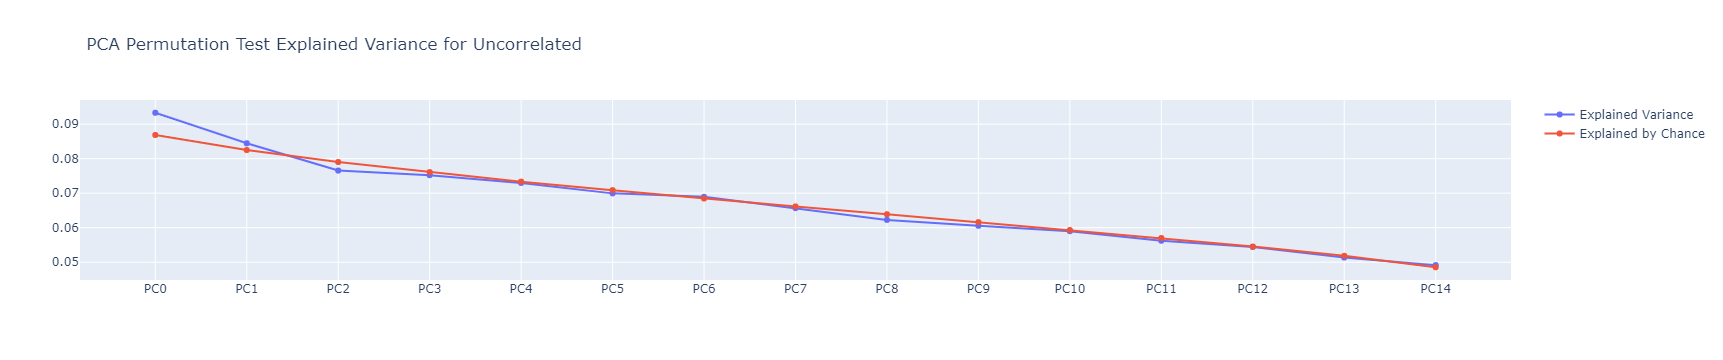

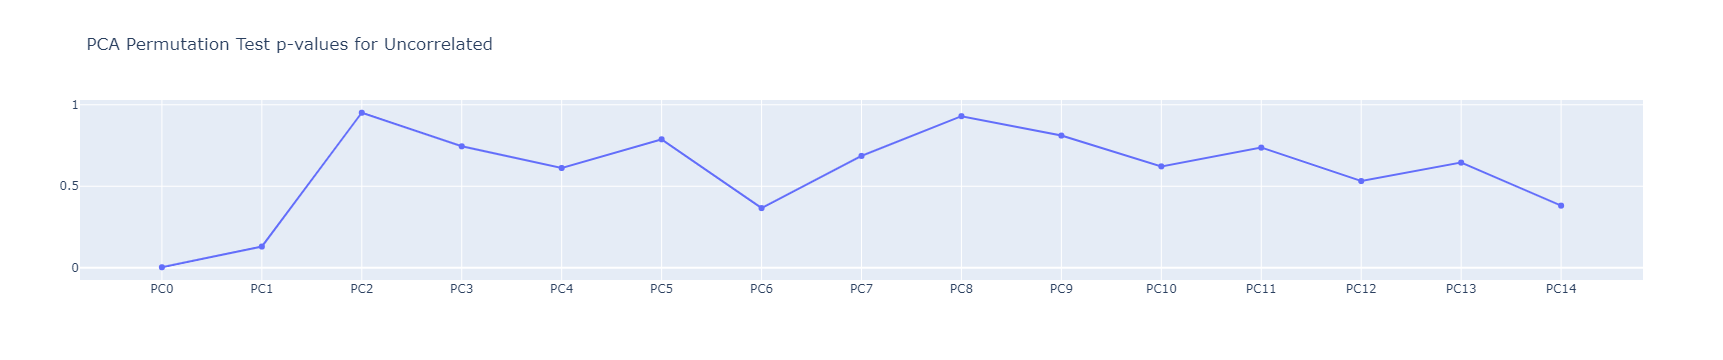

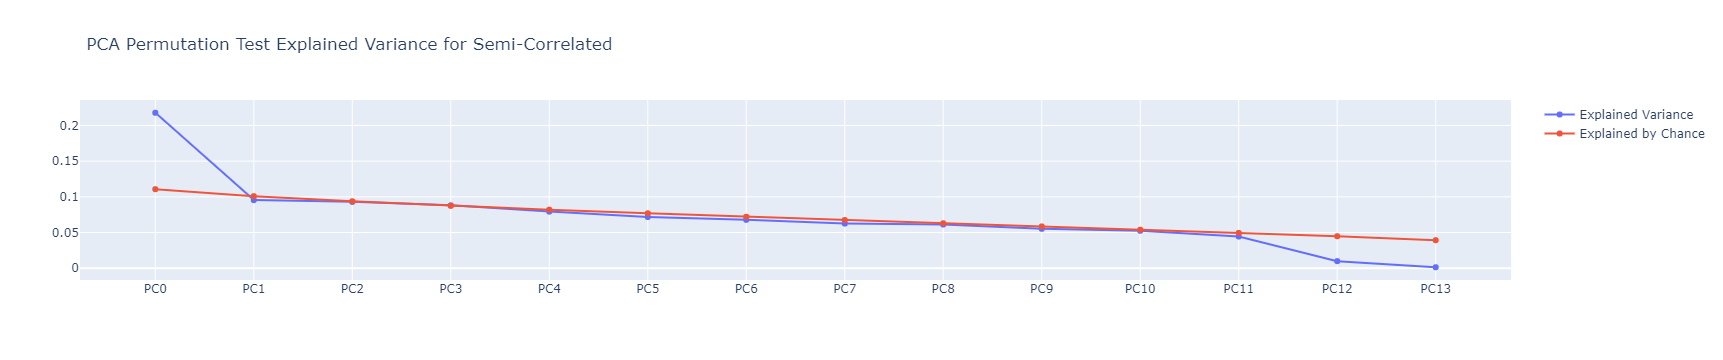

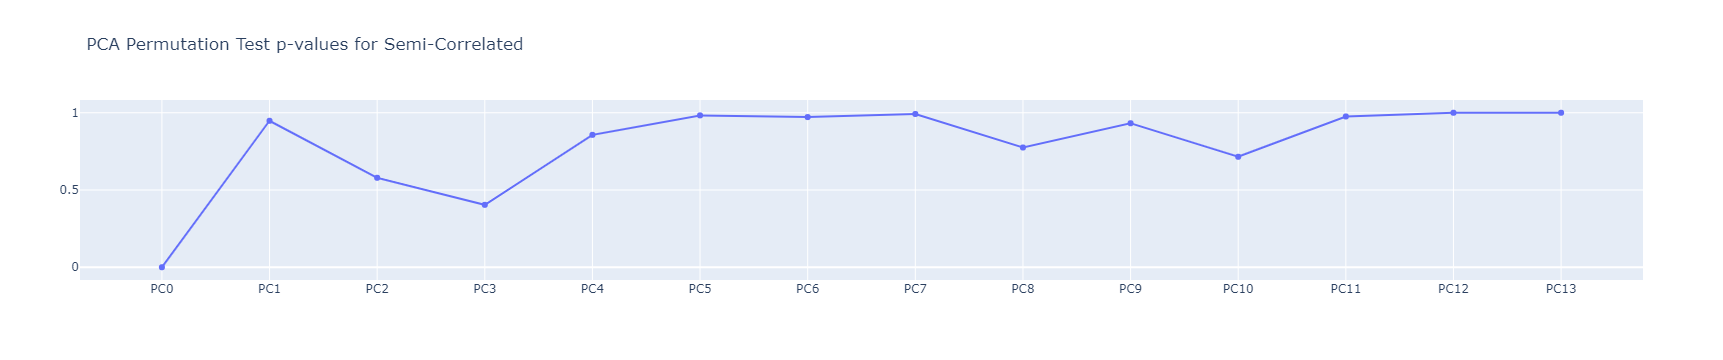

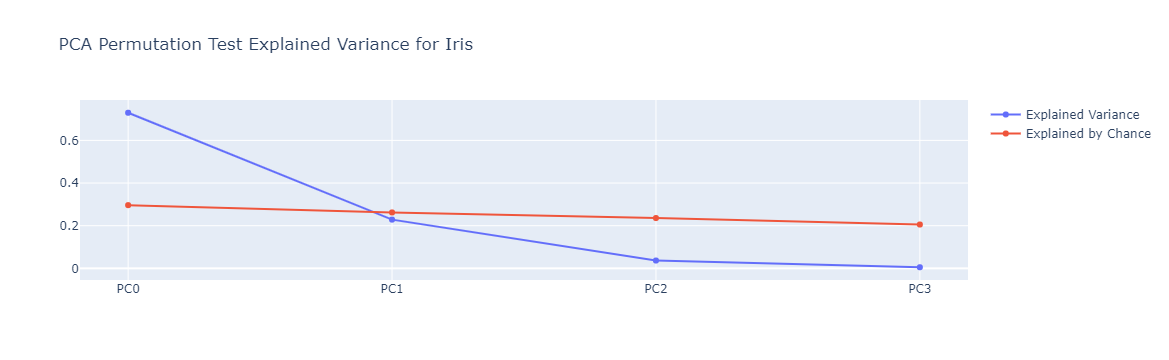

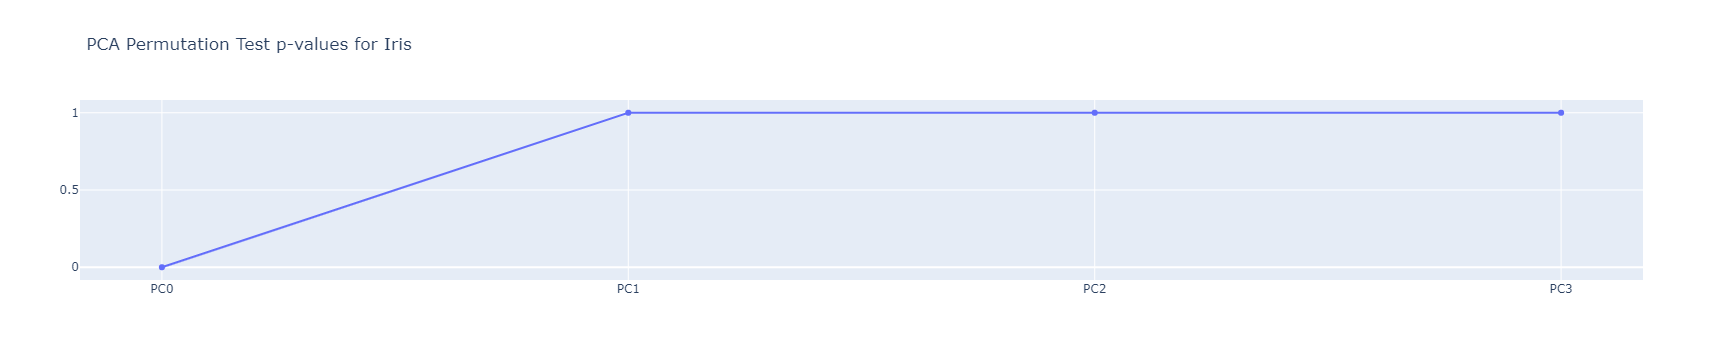

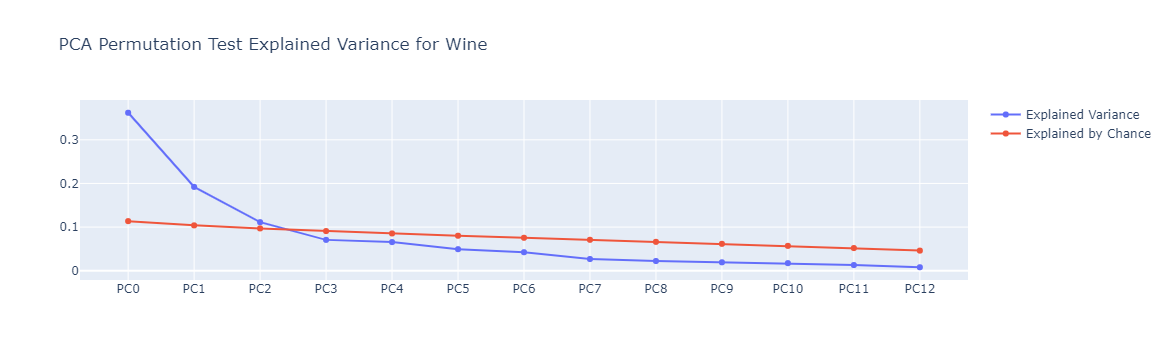

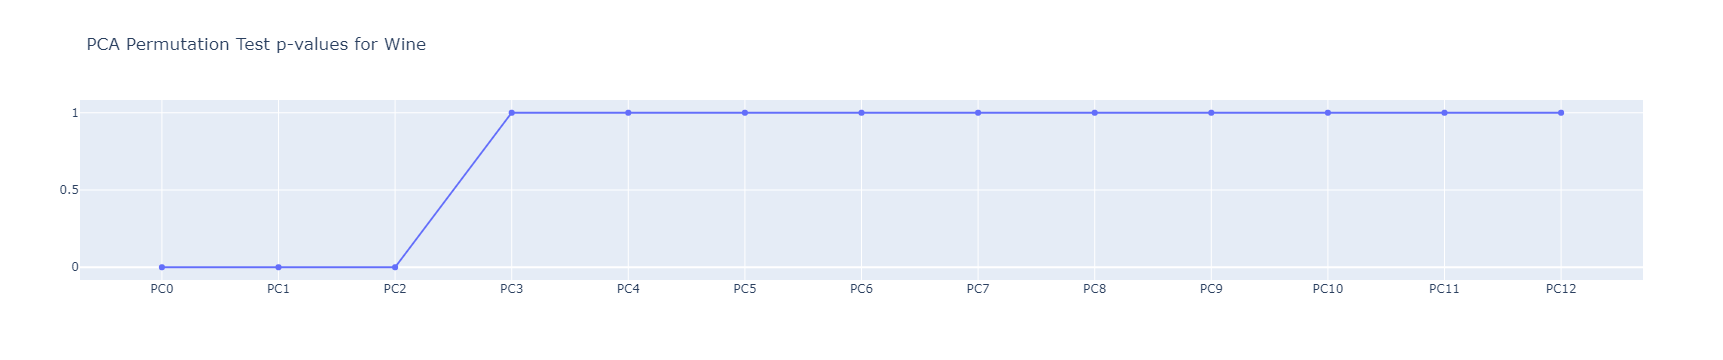

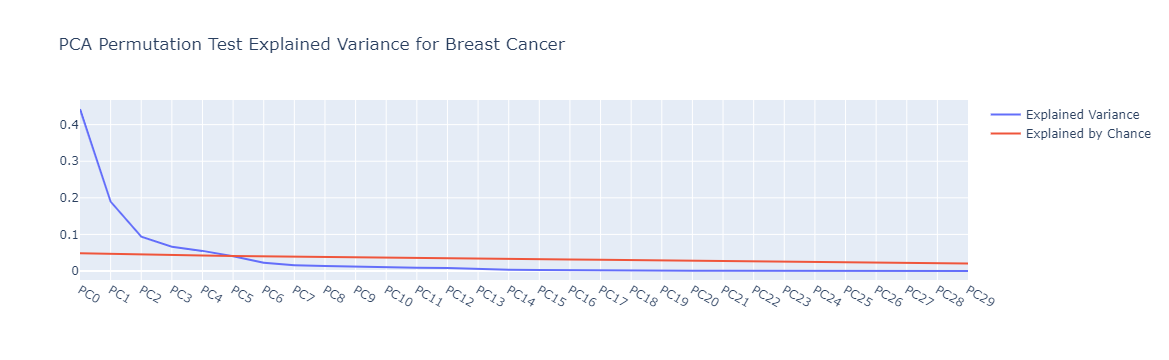

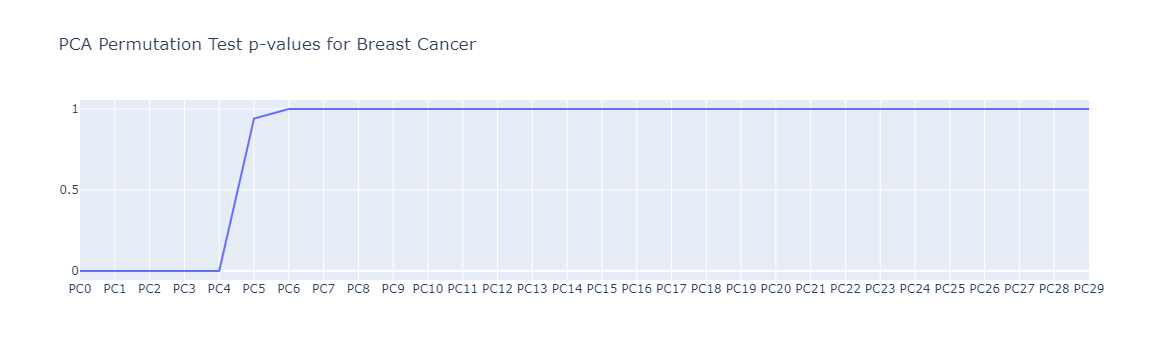

In [101]:
N_permutations = 1000
p_vals_components = []

for j, X in enumerate(datasets_X):
    df = pd.DataFrame(X)
    pca = PCA()
    pca.fit(df)

    original_variance = pca.explained_variance_ratio_
    variance = np.zeros((N_permutations, len(df.columns)))
    
    for i in range(N_permutations):
        X_aux = de_correlate_df(df)

        pca.fit(X_aux)
        variance[i, :] = pca.explained_variance_ratio_
        
    average_permuted_variance = np.mean(variance, axis=0)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[f'PC{k}' for k in range(len(df.columns))], y=original_variance, name='Explained Variance'))
    fig.add_trace(go.Scatter(x=[f'PC{k}' for k in range(len(df.columns))], y=average_permuted_variance, name='Explained by Chance'))
    fig.update_layout(title=f"PCA Permutation Test Explained Variance for {names[j]}")
    fig.show()
    
    p_val = np.sum(variance > original_variance, axis=0) / N_permutations

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[f'PC{k}' for k in range(len(df.columns))], y=p_val, name='p-value on significance'))

    fig.update_layout(title=f"PCA Permutation Test p-values for {names[j]}")
    fig.show()
    
    p_vals_components.append(np.sum(p_val < 0.05))

### Applying the model

In [102]:
def fit_rf(X, y, i):
    rf = RandomForestClassifier(random_state=i, n_jobs=-1)

    parameters = {'n_estimators': [10, 50, 100, 300], 'max_depth': [None, 3, 10]}

    clf = GridSearchCV(rf, parameters)
    clf.fit(X, y)
    
    return clf.best_estimator_

In [103]:
def validate_model(clf, X, y):
    df = pd.DataFrame()
    names_ = [f'cross_{i}' for i in range(5)]

    values = cross_val_score(clf, X, y, cv=5)

    df['values'] = values
    df = df.T
    df.columns = names_
    df['average'] = df[names_].mean(axis=1).values[0]
    df['std'] = df[names_].std(axis=1).values[0]
    return df

In [105]:
results = pd.DataFrame()

for i in tqdm(range(len(datasets_X))):
    for w in range(15):
        # Fit without PCA
        clf = fit_rf(datasets_X[i], np.array(datasets_y[i]).ravel(), w)

        df_val = validate_model(clf, datasets_X[i], np.array(datasets_y[i]).ravel())
        df_val['type'] = 'Without PCA'
        df_val['Dataset'] = names[i]
        df_val['n_components'] = 0
        df_val['round'] = w
        results = results.append(df_val, ignore_index=True)

        # Fit with PCA with all components
        pca = PCA()
        X = pca.fit_transform(datasets_X[i])
        clf = fit_rf(X, np.array(datasets_y[i]).ravel(), w)

        df_val = validate_model(clf, datasets_X[i], np.array(datasets_y[i]).ravel())
        df_val['type'] = 'PCA All Components'
        df_val['Dataset'] = names[i]
        df_val['n_components'] = X.shape[1]
        df_val['round'] = w
        results = results.append(df_val, ignore_index=True)


        # Fit PCA with 80%
        pca = PCA()
        pca.fit(datasets_X[i])

        n_components = np.sum((np.cumsum(pca.explained_variance_ratio_) <= 0.8))
        if n_components == 0:
            n_components = 1
        pca = PCA(n_components=n_components)

        X = pca.fit_transform(datasets_X[i])
        clf = fit_rf(X, np.array(datasets_y[i]).ravel(), w)

        df_val = validate_model(clf, datasets_X[i], np.array(datasets_y[i]).ravel())
        df_val['type'] = 'PCA 80%'
        df_val['Dataset'] = names[i]
        df_val['n_components'] = n_components
        df_val['round'] = w
        results = results.append(df_val, ignore_index=True)

        # Fit with PCA with permutation test components
        n_components = p_vals_components[i]
        if n_components == 0:
            n_components = 1
        pca = PCA(n_components=n_components)
        X = pca.fit_transform(datasets_X[i])
        clf = fit_rf(X, np.array(datasets_y[i]).ravel(), w)

        df_val = validate_model(clf, datasets_X[i], np.array(datasets_y[i]).ravel())
        df_val['type'] = 'PCA Permutation Test Components'
        df_val['Dataset'] = names[i]
        df_val['n_components'] = n_components
        df_val['round'] = w
        results = results.append(df_val, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [1:14:09<00:00, 889.85s/it]


### Verifying Results

In [120]:
use_metrics.pivot(index='dataset', columns='metric', values='value').reset_index().sort_values('generalized_variance')

metric,dataset,divergence_statistic,generalized_variance,index_of_matrix,information_statistic,psi_index,scatter_coefficient
0,Breast Cancer,5044.701005,7.302237e-33,315.955801,35.323471,196.077668,6.939081e-33
4,Wine,12.141029,3.857912e-05,6.746913,3.832728,20.116901,3.605716e-05
2,Semi-Correlated,29.481371,3.678815e-04,12.777970,2.677825,6.478079,3.372431e-04
1,Iris,26.262633,2.068497e-03,11.869678,2.407353,5.375048,2.027403e-03
3,Uncorrelated,0.238660,5.405816e-02,1.377891,0.118836,0.488140,5.256405e-02


As we can see the metrics were able of finding that the uncorrelated dataset is not suitable for PCA. By looking at that one can predict that the Breast Cancer dataset will be the one with greater impact from the PCA since its metrics have a huge difference. 

In [107]:
results.to_parquet('results.parquet')

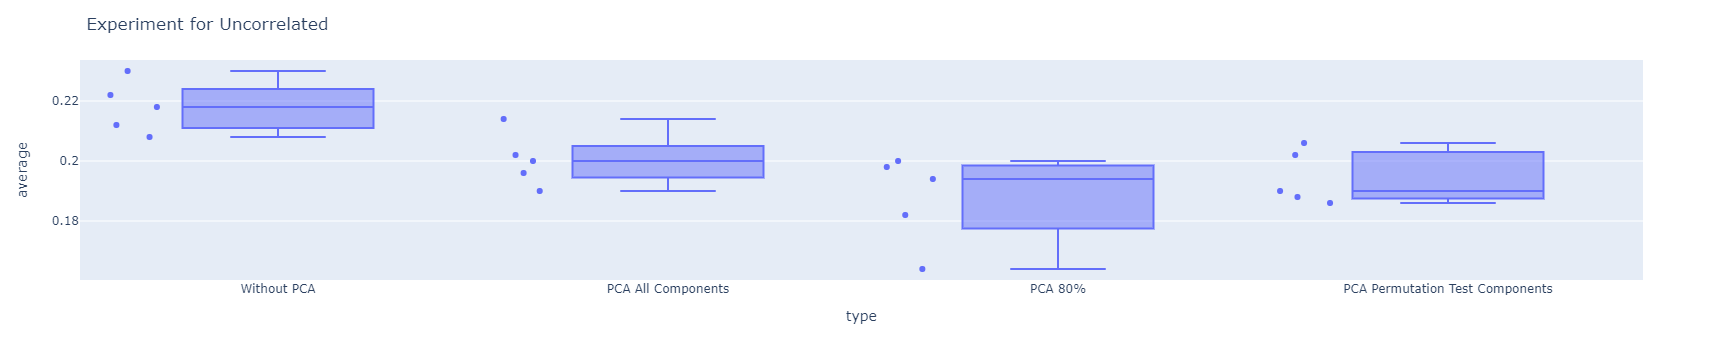

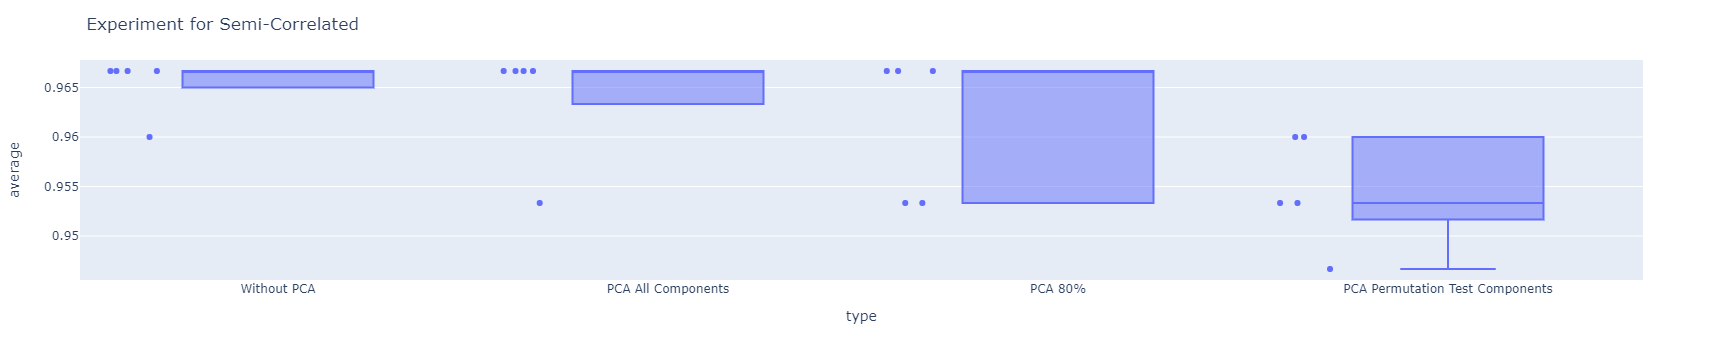

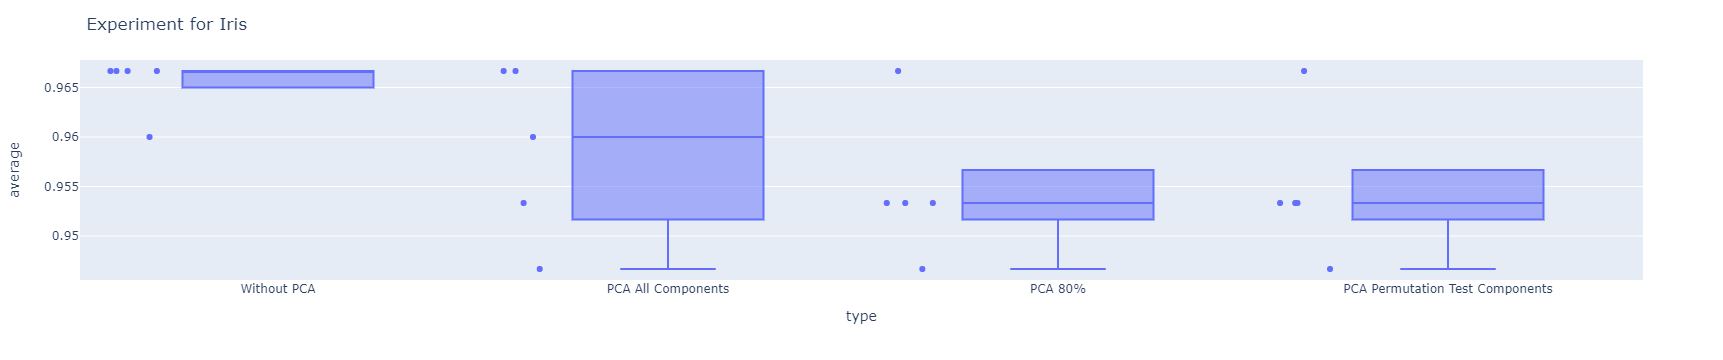

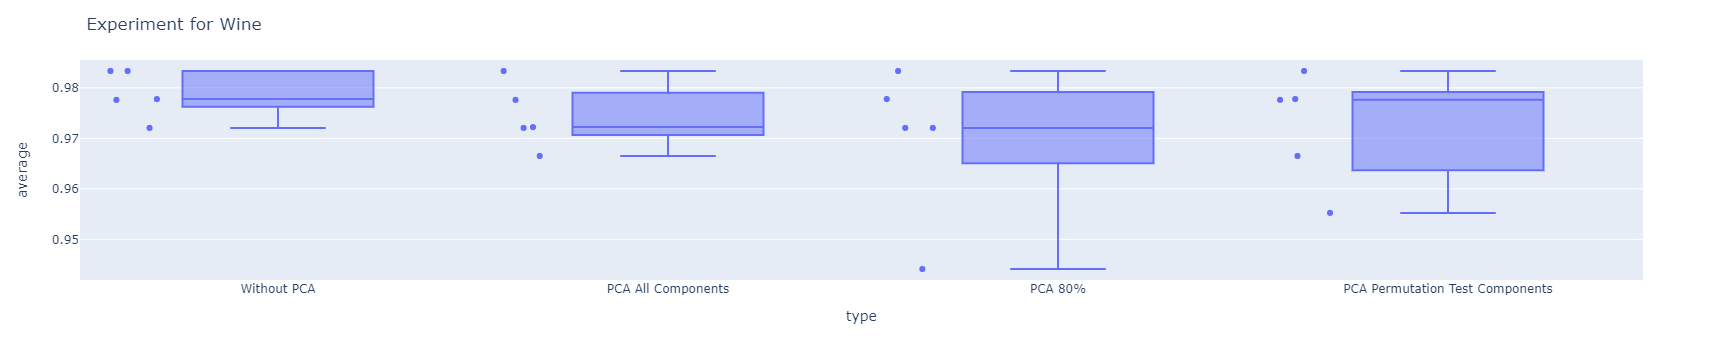

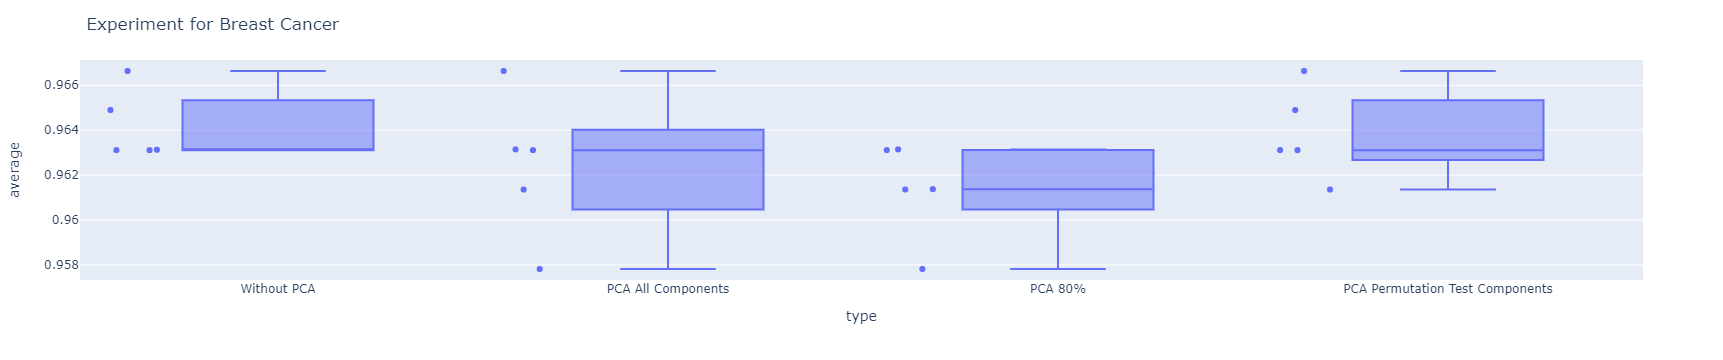

In [114]:
for dataset in results['Dataset'].unique():
    df = results[(results['Dataset'] == dataset)]
    fig = px.box(df, x='type', y='average', points='all')
    fig.update_layout(title_text=f'Experiment for {dataset}')
    fig.show()